<a href="https://colab.research.google.com/github/ayushm-agrawal/Federated-Learning-Implementations/blob/master/FederatedAveraging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time
import csv

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary
from collections import defaultdict

# Check assigned GPU
# CPUA makes things run faster
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 47

# general reproducibility
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Mon Oct  3 01:59:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.48       Driver Version: 517.48       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:02:00.0  On |                  N/A |
| 34%   54C    P0    44W / 200W |   7925MiB /  8192MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load the MNIST Dataset

In [2]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transform_train = transforms.Compose([
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                                    ])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                                   ])

cifar_data_train = datasets.CIFAR10('./data/cifar10/', train=True, download=True, transform=transform_train)
cifar_data_test = datasets.CIFAR10('../data/cifar10/', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
classes = np.array(list(cifar_data_train.class_to_idx.values()))
classes_test = np.array(list(cifar_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))

Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [4]:
print("Image Shape: {}".format(cifar_data_train.data[0].shape))


Image Shape: (32, 32, 3)


## Visualize Data

In [5]:
def imshow(img):
  #img = img/2 + 0.5 #unnormalize the image
  plt.imshow(img, cmap='hsv') # convert from tensor to image

In [6]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, int(20/2), i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    #data = data.numpy()

    target = dataset.targets[i]
    #target = target.numpy()
    imshow(data)
    axis.set_title(target)

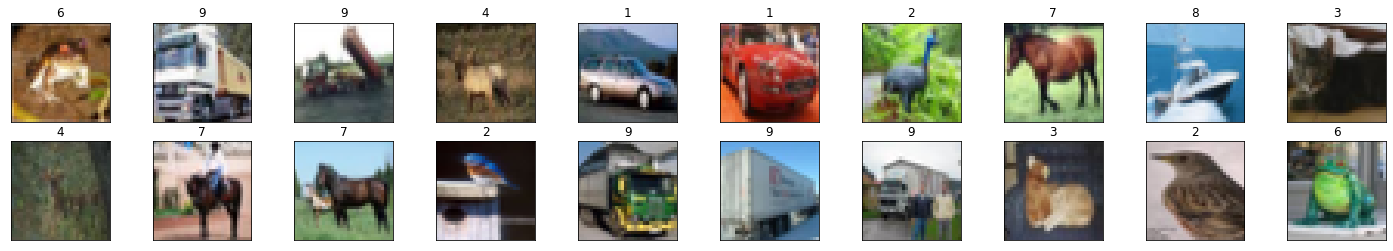

In [7]:
visualize(cifar_data_train)

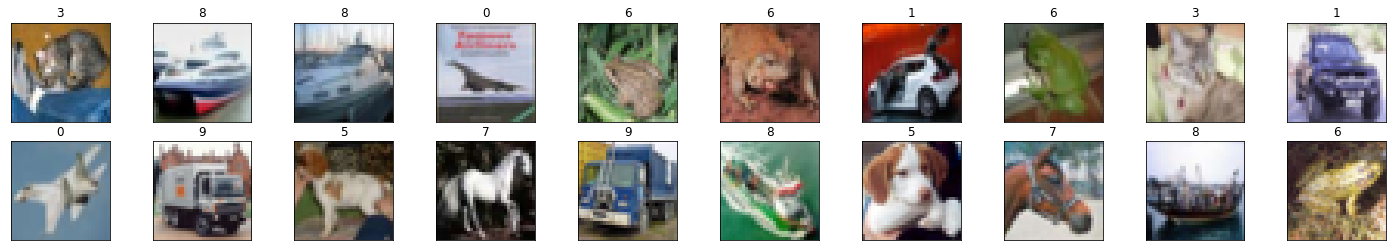

In [8]:
visualize(cifar_data_test)

## Partitioning the Data (IID and non-IID)

In [9]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    np.random.seed(seed)
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [10]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
#   data_labels = dataset.targets.numpy()
  data_labels = np.array(dataset.targets)

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    np.random.seed(seed)
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict


## Models

In [11]:
class MNIST_CNN_S(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN_S, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.5)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

In [12]:
class CIFAR_CNN(nn.Module):
  def __init__(self):
    super(CIFAR_CNN, self).__init__()

    self.conv_layer = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.fc_layer = nn.Sequential(
      nn.Linear(4096, 1024),
      nn.ReLU(),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Linear(512, 10)
    )


  def forward(self, x):      
    # conv layers
    x = self.conv_layer(x)
    
    # flatten
    x = x.view(x.size(0), -1)
    
    # fc layer
    x = self.fc_layer(x)
    
    output = F.log_softmax(x, dim=1)

    return output

In [13]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2)
    self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2)
    self.pool = nn.MaxPool2d(2,2)
    self.dropout1 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(784, 32)
    self.fc2 = nn.Linear(32, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

#     self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
#     self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
    
#     self.pool = nn.MaxPool2d(2,2)
#     self.dropout1 = nn.Dropout(p=0.25)
#     self.dropout2 = nn.Dropout(p=0.25)
#     self.fc1 = nn.Linear(3136, 512)
#     self.out = nn.Linear(512, 10)

#   def forward(self, x):
#     x = self.pool(F.relu(self.conv1(x)))
#     x = self.pool(F.relu(self.conv2(x)))
#     x = self.dropout1(x)
#     x = torch.flatten(x, 1)
#     x = F.relu(self.fc1(x))
#     x = self.dropout2(x)
#     x = self.out(x)
#     out = F.log_softmax(x, dim=1)

#     return out

### Print Model Summaries

In [14]:
cifar_cnn = CIFAR_CNN()
mnist_cnn = MNIST_CNN()
mnist_cnn_s = MNIST_CNN_S()

if torch.cuda.is_available():
  cifar_cnn.cuda()
  mnist_cnn.cuda()
  mnist_cnn_s.cuda()    

print("\nCIFAR CNN SUMMARY")
print(summary(cifar_cnn, (3, 32, 32)))
    
print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28, 28)))

print("\nMNIST CNN S SUMMARY")
print(summary(mnist_cnn_s, (1, 28, 28)))


CIFAR CNN SUMMARY
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 4, 4]           --
|    └─Conv2d: 2-1                       [-1, 32, 32, 32]          896
|    └─BatchNorm2d: 2-2                  [-1, 32, 32, 32]          64
|    └─ReLU: 2-3                         [-1, 32, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 64, 32, 32]          18,496
|    └─BatchNorm2d: 2-5                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-6                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-7                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-8                       [-1, 128, 16, 16]         73,856
|    └─BatchNorm2d: 2-9                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-10                        [-1, 128, 16, 16]         --
|    └─Conv2d: 2-11                      [-1, 128, 16, 16]         147,584
|    └─BatchNorm2d: 2-12                 [-1, 128,

## Federated Averaging

### Testing Loop

In [15]:
def testing_loop(model, dataset, bs, criterion, num_classes, classes):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs, pin_memory=True)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:
        
    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()
        
    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)

  test_accuracy = 100. * np.sum(correct_class) / np.sum(total_class)

  return test_loss, test_accuracy

### Local Training (Client Update)

Local training for the model on client side

In [16]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True, pin_memory=True)
    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0
      model.train()
      for data, labels in self.train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)            
            
      #print('Cur Battery: {}...'.format(self.battery))
      #print('Final Battery: {}...'.format(self.battery))
      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss

### Server Side Training

Following Algorithm 1 from the paper

In [17]:
def training(model, rounds, batch_size, lr, ds, data_dict, CLIENT_FRACTION, TOTAL_CLIENTS, TRAINING_EPOCHS,\
             LOWP_TRAINING_EPOCHS, HIGHP_CLIENT_PERCENTAGE, plt_title, plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:                    PyTorch model to train
    - rounds:                   Number of communication rounds for the client update
    - batch_size:               Batch size for client update training
    - lr:                       Learning rate used for client update training
    - ds:                       Dataset used for training
    - data_dict:                Type of data partition used for training (IID or non-IID)
    - CLIENT_FRACTION:          Fraction of clients randomly chosen to perform computation on each round
    - TOTAL_CLIENTS:            Total number of clients
    - TRAINING_EPOCHS:          Number of training passes each client makes over its local dataset per round
    - HIGHP_CLIENT_PERCENTAGE:  High/Low battery distribution   
    - tb_writer_name:           Directory name to save the tensorboard logs
  Returns:  
    - model:                Trained model on the server
  """ 

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []

  # test accuracy
  test_acc = []

  # index of clients deleted for low battery
  deleted_clients = []

  xaxiss = 0
  break_counter = 0
  
  # measure time
  start = time.time()
    
  # create list of dictionary for dict_id, battery, sim-martix
  client_info = [{} for sub in range(TOTAL_CLIENTS)]


  # initialize all client battery
  np.random.seed(seed)
  LOWP_CLIENTS = np.random.uniform(low=30.0, high=35.0, size=round((1-HIGHP_CLIENT_PERCENTAGE)*TOTAL_CLIENTS))  
  HIGHP_CLIENTS = np.random.uniform(low=80.0, high=100.0, size=int(HIGHP_CLIENT_PERCENTAGE*TOTAL_CLIENTS)) 
  CLIENTS_BATTERY = np.concatenate((LOWP_CLIENTS, HIGHP_CLIENTS), axis=0)
  np.random.shuffle(CLIENTS_BATTERY)
    
  # add all client battery to dict
  for ids, currdict in enumerate(client_info):
    currdict['ID']=ids
    currdict['Battery']=CLIENTS_BATTERY[ids]
    currdict['Round_trained']=0
    currdict['Matrix'] = []


  for curr_round in range(1, rounds+1):
    
    w, local_loss = [], []
    NUM_CLIENTS = max(int(CLIENT_FRACTION*TOTAL_CLIENTS), 1)

#     np.random.seed(seed)
    BATTERY_COST = np.random.uniform(0.8, 1, TOTAL_CLIENTS)
        
    width, height = len(client_info), len(client_info)

    
    TRAINING_CLIENTS = []
    
    # break if the clients left are all high power client  
    if(len(client_info) == len(HIGHP_CLIENTS)):
      break_counter += 1
#       xaxiss = curr_round
#       break


    #getting the first matrix
    
    if curr_round==1:
      matrix_counter = len(client_info)
      # Creates the matrix
#       allw = [[0 for x in range(width)] for y in range(height)] 
      allw = np.zeros((width, height))
      # Going through all client_info and find the client that have recently enough matrix use them instead of finding new
      for i in range(len(client_info)):
        local_update = ClientUpdate(cifar_data_train, batch_size, lr, 1, data_dict[client_info[i]['ID']])
        matrix_weights, matrix_loss = local_update.train(model=copy.deepcopy(model))
        for k in matrix_weights.keys():
          client_info[i]['Matrix'] += list(np.array(torch.flatten(matrix_weights[k]).detach().cpu().numpy()))
        client_info[i]['Battery'] -= np.random.uniform(0.4, 0.5)
      
       # Going through all clients and calculate the similarity matrix for all clients
      for ids, curr_client in enumerate(client_info):        
        matrix_counter-=1
        dict_id = ids
#         print("ROUND 1")
#         print(len(client_info[ids]['Matrix']))
        allw[ids][ids] = np.vdot(client_info[ids]['Matrix'], client_info[ids]['Matrix'])
        for i in range (matrix_counter):
          dict_id+=1
          allw[ids][dict_id] = np.vdot(client_info[ids]['Matrix'], client_info[dict_id]['Matrix'])        
      #normalize all the clients weight     
      for i in range(width):
        temp_max = np.amax(allw[i])
#       temp_max = allw[i][i]
        for j in range(height):
          if allw[i][j] != 0:
            allw[i][j] = allw[i][j]/temp_max

      #enter the weights into each clients' row     
      for i in range(width):
        for j in range(height):
          if allw[i][j] == 0:
            allw[i][j] = allw[j][i]
        
      #get total similarity matrix by adding the local weights of each client together    
      total_wmatrix =[]
      for i in range(width):
        temprow=0
        for j in range(height):
          temprow += allw[i][j]
        total_wmatrix.append(temprow)
    
      client_info = sorted(client_info, key=lambda x: x['Matrix'])
      
    
    #every 3 rounds will get matrix
    elif curr_round%4==0:
      matrix_counter = len(client_info)
      # Creates the matrix
      allw = np.zeros((width, height))
      # Going through all client_info and find the client that have recently enough matrix use them instead of finding new
      for i in range(len(client_info)):
        if client_info[i]['Round_trained'] == 0:
          local_update = ClientUpdate(cifar_data_train, batch_size, lr, 1, data_dict[client_info[i]['ID']])
          matrix_weights, matrix_loss = local_update.train(model=copy.deepcopy(model))
          client_info[i]['Matrix'].clear()
          for k in matrix_weights.keys():
            client_info[i]['Matrix'] += list(np.array(torch.flatten(matrix_weights[k]).detach().cpu().numpy()))
          client_info[i]['Battery'] -= np.random.uniform(0.4, 0.5)
  
      # Going through all clients and calculate the similarity matrix for all clients
      for ids, curr_client in enumerate(client_info):        
        matrix_counter-=1
        dict_id = ids
        allw[ids][ids] = np.vdot(client_info[ids]['Matrix'], client_info[ids]['Matrix'])
        for i in range (matrix_counter):
          dict_id+=1
          allw[ids][dict_id] = np.vdot(client_info[ids]['Matrix'], client_info[dict_id]['Matrix'])            
 
      #normalize all the clients weight     
      for i in range(width):
        temp_max = np.amax(allw[i])
        for j in range(height):
          if allw[i][j] != 0:
            allw[i][j] = allw[i][j]/temp_max

      #enter the weights into each clients' row     
      for i in range(width):
        for j in range(height):
          if allw[i][j] == 0:
            allw[i][j] = allw[j][i]
        
      #get total similarity matrix by adding the local weights of each client together    
      total_wmatrix =[]
      for i in range(width):
        temprow=0
        for j in range(height):
          temprow += allw[i][j]
        total_wmatrix.append(temprow)

      client_info = sorted(client_info, key=lambda x: x['Matrix'])
        
    temp_tClients = []
    for i in range(len(client_info)):
      if (curr_round > (client_info[i]['Round_trained']+3) or client_info[i]['Round_trained']==0):
        TRAINING_CLIENTS.append(client_info[i]['ID'])
        client_info[i]['Round_trained'] = curr_round
        if(len(TRAINING_CLIENTS) == NUM_CLIENTS/2):
          temp_tClients.append(client_info[i]['ID'])
          break
        
    for i in range(len(client_info)-1, -1, -1):
      if (curr_round > (client_info[i]['Round_trained']+3) or client_info[i]['Round_trained']==0) and client_info[i]['ID']\
      not in temp_tClients:
        TRAINING_CLIENTS.append(client_info[i]['ID'])
        client_info[i]['Round_trained'] = curr_round
        if(len(TRAINING_CLIENTS) == NUM_CLIENTS):
          break
    if len(TRAINING_CLIENTS)<NUM_CLIENTS:
      for i in range(len(client_info)-1, -1, -1):
        TRAINING_CLIENTS.append(client_info[i]['ID'])
        client_info[i]['Round_trained'] = curr_round     
        if(len(TRAINING_CLIENTS) == NUM_CLIENTS):
          break

    print("TRAINING_CLIENTS")
    print(TRAINING_CLIENTS)
    print(allw)
    
#     if not TRAINING_CLIENTS:
#       break
#     else:
#       xaxiss = curr_round      

    
    #Training Starts:
    for client_id in TRAINING_CLIENTS:
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=TRAINING_EPOCHS, \
                                  idxs=data_dict[client_id])        
      weights, loss = local_update.train(model=copy.deepcopy(model))
      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
        
      for i in range(len(client_info)):
        if client_info[i]['ID'] == client_id:
          client_info[i]['Battery'] -= BATTERY_COST[client_id]
          client_info[i]['Matrix'].clear()
          for k in weights.keys():
            client_info[i]['Matrix']+=(list(np.array(torch.flatten(weights[k]).cpu())))

    
    # client battery decaying per round  
    for client_id in range(len(client_info)):
#       np.random.seed(seed)
      client_info[client_id]['Battery'] -= np.random.uniform(0.2, 0.5)

    # print current client_info  
    for i in client_info:
      print (str(i['ID']) + '  ' + str(i['Battery']) + '  ' + str(i['Round_trained']))     
    
    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    
    criterion = nn.CrossEntropyLoss()
    
    test_loss, test_accuracy = testing_loop(model, cifar_data_test, 128, criterion, num_classes, classes_test)
    print(f"Round: {curr_round}... \tAverage Train Loss: {round(loss_avg, 5)}... \tTest Loss: {round(test_loss, 5)}... \
    \tTest Accuracy: {round(test_accuracy, 5)}")
    
    train_loss.append(loss_avg)
    test_acc.append(test_accuracy)
        
    #delete low power client
    entries_to_remove = []

    for client_id in range(len(client_info)):
      if client_info[client_id]['Battery'] <20:  
        entries_to_remove.append(client_info[client_id]['ID'])
        
    while entries_to_remove:
      for client_id in range (len(client_info)):
        if client_info[client_id]['ID'] == entries_to_remove[-1]:
          del client_info[client_id]
          entries_to_remove.pop()
          break
    
  if (xaxiss==0):
    xaxiss=rounds+1        
  end = time.time()
  fig, ax = plt.subplots()
  x_axis = np.arange(1, xaxiss)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss', title=plt_title)
  ax.grid()
  # fig.savefig(plt_title+'-'+ str(rounds) +'-'+ str(HIGHP_CLIENT_PERCENTAGE)+'.jpg', format='jpg')
    
  # plot test accuracy
  fig1, ax1 = plt.subplots()
  x_axis1 = np.arange(1, xaxiss)
  y_axis1 = np.array(test_acc)
  ax1.plot(x_axis1, y_axis1)

  ax1.set(xlabel='Number of Rounds', ylabel='Test Accuracy', title=plt_title)
  ax1.grid()
  # fig1.savefig(plt_title+'-test.jpg', format='jpg')
    
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))  
    
  with open(plt_title +'-'+ str(rounds) +'-'+ str(HIGHP_CLIENT_PERCENTAGE) +'.csv', 'w', newline='') as csvfile:
    fieldnames = ['round', 'test_accuracy']
    thewriter = csv.DictWriter(csvfile, fieldnames=fieldnames)
    thewriter.writeheader()
    for ids, k in enumerate(x_axis1):
      thewriter.writerow({'round':k, 'test_accuracy':y_axis1[ids]})
  
  return model

## Testing Loop

In [18]:
def testing(model, dataset, bs, criterion, num_classes, classes):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs, pin_memory=True)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print("Test Loss: {:.6f}\n".format(test_loss))

  # print test accuracy
  for i in range(10):
    if total_class[i]>0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
            (classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i])))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
        100. * np.sum(correct_class) / np.sum(total_class),
        np.sum(correct_class), np.sum(total_class)))

## MNIST CNN on IID

### Train


TRAINING_CLIENTS
[16, 7]
[[1.         0.99976003 0.99959924 0.99956128 0.99958124 0.99972772
  0.99955249 0.99964783 0.99973086 0.99960513 0.9995958  0.99953743
  0.99978608 0.9996298  0.99973958 0.99974638 0.99971877 0.9998552
  0.99966154 0.99959099]
 [0.99976003 1.         0.99971087 0.99965164 0.99956115 0.99974838
  0.99954262 0.99970396 0.99987034 0.99968272 0.99974371 0.99956857
  0.99978479 0.99974118 0.99981065 0.99972927 0.99983146 0.99981275
  0.99971415 0.99961982]
 [0.99959924 0.99971087 1.         0.99981618 0.99975489 0.99991153
  0.99974663 0.99987327 0.99991338 0.99987835 0.99993113 0.9997902
  0.99990206 0.99986914 0.99988736 0.99989729 0.9998913  0.99994702
  0.99990758 0.99981516]
 [0.99956128 0.99965164 0.99981618 0.9999845  0.99978329 0.99996276
  0.99976122 0.99988591 0.99990981 0.99988937 0.99987041 0.99982145
  0.99994979 0.99989535 1.         0.99994328 0.99993791 0.99995606
  0.99988158 0.99986828]
 [0.99958124 0.99956115 0.99975489 0.99978329 0.99995027 0.99

16  84.53722822953725  1
5  83.85775224982537  2
3  30.96814219324859  0
10  83.98992899499548  0
0  32.39995477314066  0
12  30.652379643242924  0
13  84.31286006964747  0
11  91.5606096789564  0
9  84.09265076773913  0
17  31.983077843953136  0
18  30.069362138283307  0
2  97.50326365381798  0
14  79.45794984855227  0
6  82.57201847482447  0
8  32.17936737619262  0
4  32.46488427866396  0
1  29.3947312706232  0
15  33.77075217897982  0
19  31.963689409775654  2
7  79.79178824561816  1
Round: 2... 	Average Train Loss: 0.5435... 	Test Loss: 3.20578...     	Test Accuracy: 20.63291
TRAINING_CLIENTS
[3, 15]
[[1.         0.99976003 0.99959924 0.99956128 0.99958124 0.99972772
  0.99955249 0.99964783 0.99973086 0.99960513 0.9995958  0.99953743
  0.99978608 0.9996298  0.99973958 0.99974638 0.99971877 0.9998552
  0.99966154 0.99959099]
 [0.99976003 1.         0.99971087 0.99965164 0.99956115 0.99974838
  0.99954262 0.99970396 0.99987034 0.99968272 0.99974371 0.99956857
  0.99978479 0.99974118 

9  82.05978420812984  4
10  83.0156897024921  0
17  30.856949163462538  0
4  31.305951851753402  0
2  96.23074194408376  0
1  28.1478209690334  0
18  28.93652146491533  0
15  31.952189312316893  3
13  83.08991972741525  0
3  29.42151790702425  3
8  30.839305451759902  0
7  79.23082101465381  1
0  31.17657379730979  0
6  81.538285067816  0
11  90.408304872684  0
14  78.40069762130362  0
12  28.69935891169354  4
5  83.16050131995088  2
16  83.68486538227506  1
19  31.149897992771415  2
Round: 4... 	Average Train Loss: 0.53658... 	Test Loss: 3.32013...     	Test Accuracy: 29.62025
TRAINING_CLIENTS
[10, 16]
[[0.31352095 0.62555244 0.93758922 0.99999417 0.999996   0.99999592
  0.99999397 0.99999378 0.99999407 0.99999728 1.         0.99999386
  0.99999511 0.99999355 0.99999503 0.9999935  0.99999596 0.93758802
  0.62554979 0.31350711]
 [0.62555244 0.62528103 0.93754449 0.99999669 0.99999781 0.99999764
  0.99999663 0.99999631 0.99999717 0.99999839 1.         0.99999657
  0.99999707 0.99999686 

9  81.1744528729093  4
10  81.31282248981621  5
17  29.448834662940712  6
4  30.775213782640677  0
2  95.37882950081074  0
1  27.433757387750155  0
18  28.269263390401974  0
15  31.23370958845146  3
13  82.16886476403454  0
3  28.4346059482235  3
8  30.168735649419137  0
7  78.49918069794424  1
0  30.474516592044523  0
6  80.98064016513189  0
11  89.57289874015025  0
14  77.58352530117581  0
12  27.992186857250573  4
5  82.48225430266362  2
16  81.94699877324851  5
19  29.422887499581847  6
Round: 6... 	Average Train Loss: 0.35315... 	Test Loss: 2.67321...     	Test Accuracy: 28.73418
TRAINING_CLIENTS
[4, 5]
[[0.31352095 0.62555244 0.93758922 0.99999417 0.999996   0.99999592
  0.99999397 0.99999378 0.99999407 0.99999728 1.         0.99999386
  0.99999511 0.99999355 0.99999503 0.9999935  0.99999596 0.93758802
  0.62554979 0.31350711]
 [0.62555244 0.62528103 0.93754449 0.99999669 0.99999781 0.99999764
  0.99999663 0.99999631 0.99999717 0.99999839 1.         0.99999657
  0.99999707 0.9999

15  29.688766254242143  8
12  27.28853052432885  4
3  27.715218093239  3
7  77.93917255070834  1
9  80.61874627801828  4
8  29.01830691249837  0
10  80.64185543915248  5
18  26.94592394447927  0
2  94.23387034341062  0
14  76.32248805857448  0
6  79.83655324222832  0
13  80.97428100486847  0
5  80.62846558795339  7
4  28.959342345578307  7
1  26.274681461930985  0
11  88.48714389550652  0
17  28.83662208802545  6
0  28.4291525322606  8
16  81.0970452979579  5
19  28.8006831952221  6
Round: 8... 	Average Train Loss: 0.39885... 	Test Loss: 3.13109...     	Test Accuracy: 35.06329
TRAINING_CLIENTS
[12, 16]
[[0.55563066 0.69449565 0.83336138 0.97222613 0.99999915 0.9999997
  1.         0.41676472 0.99999936 0.41676477 0.99999934 0.13903104
  0.99999936 0.99999915 0.99999932 0.99999955 0.55562983 0.97222643
  0.69449546 0.833361  ]
 [0.69449565 0.69448601 0.83335591 0.97222542 0.99999938 0.99999981
  1.         0.41674482 0.99999958 0.41674504 0.99999951 0.13900248
  0.99999952 0.99999934 0.

15  28.93603182147812  8
12  25.53118284828736  9
3  26.08124520169207  10
7  77.13264522043613  1
9  79.90992992735715  4
8  28.365063259887346  0
10  79.97050790831808  5
18  26.303400920978053  0
2  93.35385328314021  0
14  75.6049816998458  0
6  79.18377115324246  0
13  80.20281627449046  0
5  79.73926055784136  7
4  28.20530413441171  7
1  25.60968557505486  0
11  87.69878321847523  0
17  28.054652679513648  6
0  27.62122896552537  8
16  79.26457972469385  9
19  27.432322747206808  10
Round: 10... 	Average Train Loss: 0.35237... 	Test Loss: 3.28082...     	Test Accuracy: 34.43038
TRAINING_CLIENTS
[7, 17]
[[0.55563066 0.69449565 0.83336138 0.97222613 0.99999915 0.9999997
  1.         0.41676472 0.99999936 0.41676477 0.99999934 0.13903104
  0.99999936 0.99999915 0.99999932 0.99999955 0.55562983 0.97222643
  0.69449546 0.833361  ]
 [0.69449565 0.69448601 0.83335591 0.97222542 0.99999938 0.99999981
  1.         0.41674482 0.99999958 0.41674504 0.99999951 0.13900248
  0.99999952 0.9999

9  78.2919335497994  12
10  79.14619221741516  5
3  25.348119086077308  10
16  78.66167170299184  9
5  79.00154219679565  7
4  27.46678277873092  7
15  28.239744746246057  8
12  24.855313849320282  9
0  27.034331044464835  8
17  26.407354624088  11
18  25.029753514827284  0
13  79.11723312019191  0
8  27.426215237790924  0
11  86.5856812806325  0
1  24.41527324600431  0
2  92.02631348299332  0
19  26.756574701960314  10
14  74.47622844078273  0
7  75.6451716601394  11
6  77.06915817910591  12
Round: 12... 	Average Train Loss: 0.27896... 	Test Loss: 1.99003...     	Test Accuracy: 48.22785
TRAINING_CLIENTS
[10, 14]
[[0.71430148 0.80358206 0.89286291 0.98214364 0.35717759 0.99999983
  0.44645856 1.         0.99999975 0.99999986 0.99999972 0.99999979
  0.6250204  0.62502035 0.99999989 0.99999976 0.98214376 0.71430111
  0.80358209 0.89286272]
 [0.80358206 0.80358107 0.89286227 0.98214352 0.3571736  0.99999986
  0.44645515 1.         0.99999977 0.99999987 0.99999973 0.99999982
  0.62501804 0

9  77.40770539862719  12
10  77.82909906561767  13
3  23.643172533962083  14
16  77.85725612724076  9
5  78.25886412370973  7
4  26.8708444716262  7
15  27.7057782362252  8
12  24.200816742117222  9
0  26.397712978679078  8
17  25.606830664427147  11
18  24.202092015119423  0
13  78.4816185390996  0
8  26.809022446225946  0
11  85.79095657110186  0
1  23.769074276255065  0
2  91.41489240998304  0
19  25.200474416985628  14
14  72.86858116230117  13
7  74.9647801473273  11
6  76.42259391130413  12
Round: 14... 	Average Train Loss: 0.271... 	Test Loss: 2.53919...     	Test Accuracy: 42.1519
TRAINING_CLIENTS
[16, 7]
[[0.71430148 0.80358206 0.89286291 0.98214364 0.35717759 0.99999983
  0.44645856 1.         0.99999975 0.99999986 0.99999972 0.99999979
  0.6250204  0.62502035 0.99999989 0.99999976 0.98214376 0.71430111
  0.80358209 0.89286272]
 [0.80358206 0.80358107 0.89286227 0.98214352 0.3571736  0.99999986
  0.44645515 1.         0.99999977 0.99999987 0.99999973 0.99999982
  0.62501804 0

5  76.49992811990516  16
4  26.107256051166463  7
15  27.169635745087696  8
12  23.546673038505105  9
0  25.85817721863218  8
6  75.52507710092202  12
17  24.96530342107036  11
9  76.70572740704571  12
14  72.22238530160007  13
10  77.07419097199009  13
3  22.944548506386482  14
16  76.08705739123472  15
8  25.828266446413156  0
18  22.86749521707505  0
19  24.639912686575407  14
2  90.2424702681648  0
1  22.62372594563961  0
11  84.86130748439493  0
7  73.33091495784612  15
13  76.61683369514155  16
Round: 16... 	Average Train Loss: 0.28045... 	Test Loss: 1.90333...     	Test Accuracy: 57.08861
TRAINING_CLIENTS
[4, 11]
[[0.78947951 0.85526705 0.92105474 0.98684241 0.4605408  0.46054077
  0.52632856 0.59211624 0.52632847 0.72369174 1.         0.99999992
  0.99999992 0.99999993 0.99999997 0.99999991 0.9210547  0.85526709
  0.98684237 0.78947937]
 [0.85526705 0.85526684 0.92105459 0.98684238 0.46053965 0.46053963
  0.52632754 0.59211535 0.52632747 0.72369111 1.         0.99999994
  0.999

5  75.89229336334506  16
4  24.574707958668544  17
15  25.709745589892904  18
12  22.719145512861626  9
0  25.35431888515108  8
6  74.67287970993232  12
17  24.315713907769393  11
9  76.12527504063513  12
14  71.4883445611533  13
10  76.52943359134039  13
3  22.28090496521556  14
16  75.42754419321531  15
8  25.05554065894538  0
18  22.260138636043155  0
19  24.02807282010094  14
2  89.43583008250734  0
1  21.03879334860928  18
11  83.3249333795147  17
7  72.68013983228532  15
13  75.9062582298087  16
Round: 18... 	Average Train Loss: 0.29855... 	Test Loss: 1.01811...     	Test Accuracy: 67.34177
TRAINING_CLIENTS
[12, 7]
[[0.78947951 0.85526705 0.92105474 0.98684241 0.4605408  0.46054077
  0.52632856 0.59211624 0.52632847 0.72369174 1.         0.99999992
  0.99999992 0.99999993 0.99999997 0.99999991 0.9210547  0.85526709
  0.98684237 0.78947937]
 [0.85526705 0.85526684 0.92105459 0.98684238 0.46053965 0.46053963
  0.52632754 0.59211535 0.52632747 0.72369111 1.         0.99999994
  0.99

0  23.557063885251615  20
6  73.82709080905757  12
17  23.59390085033622  11
9  75.69394767001877  12
14  70.83863851272906  13
10  76.08665639844921  13
4  23.70296586240216  17
3  21.6161933607054  14
16  74.69004357173519  15
5  75.4742546099504  16
15  24.75876248209029  18
11  82.63152121724833  17
19  23.375819832184153  14
12  21.1978378069322  19
13  75.20638298060865  16
1  20.26522628098442  18
18  21.131843750176337  0
2  88.32600472093488  0
8  22.88417920769975  20
7  71.13637819272734  19
Round: 20... 	Average Train Loss: 0.35635... 	Test Loss: 2.2872...     	Test Accuracy: 41.51899
TRAINING_CLIENTS
[6, 2]
[[0.83333609 0.88541849 0.93750103 0.98958346 0.41667599 0.62500606
  0.57292359 0.62500607 0.67708856 0.67708855 0.72917106 0.78125356
  0.99999992 1.         0.72917102 0.99999993 0.93750099 0.8854185
  0.98958346 0.83333602]
 [0.88541849 0.88541843 0.93750098 0.98958347 0.41667543 0.6250057
  0.57292317 0.6250057  0.67708825 0.67708824 0.7291708  0.78125334
  0.99999

0  23.060825509613963  20
6  72.28633982717813  21
17  21.78953860320826  22
9  74.8891044209586  12
14  70.0774899633525  13
10  75.57543313875996  13
4  22.940835481154807  17
3  20.882642280482965  14
16  73.95074804014061  15
5  74.85641013477505  16
15  24.06540390570795  18
11  81.97695692255058  17
19  22.77689893841699  14
12  20.47923950329743  19
13  74.62224066996708  16
1  19.73801079603086  18
18  19.54844567570209  22
2  86.84354204977647  21
8  22.107363698148397  20
7  70.53235290628642  19
Round: 22... 	Average Train Loss: 0.11362... 	Test Loss: 2.01344...     	Test Accuracy: 42.27848
TRAINING_CLIENTS
[9, 7]
[[0.83333609 0.88541849 0.93750103 0.98958346 0.41667599 0.62500606
  0.57292359 0.62500607 0.67708856 0.67708855 0.72917106 0.78125356
  0.99999992 1.         0.72917102 0.99999993 0.93750099 0.8854185
  0.98958346 0.83333602]
 [0.88541849 0.88541843 0.93750098 0.98958347 0.41667543 0.6250057
  0.57292317 0.6250057  0.67708825 0.67708824 0.7291708  0.78125334
  0.

14  68.48527004005693  24
10  74.83493614832537  13
4  22.10629843726144  17
3  20.300611671449783  14
16  73.48908426784814  15
5  74.26189637300763  16
15  23.427351738020736  18
11  81.34326755348526  17
19  22.30547644480177  14
13  73.9080794701332  16
0  22.329913680607135  20
6  71.72126010690779  21
17  21.235186945095034  22
2  86.06009871739835  21
9  73.34929351408519  23
8  20.612631031369464  24
7  68.75087903838676  23
Round: 24... 	Average Train Loss: 0.264... 	Test Loss: 2.70664...     	Test Accuracy: 45.06329
TRAINING_CLIENTS
[10, 2]
[[0.86956668 0.91304444 0.95652225 1.         0.56522212 0.5652221
  0.73913327 0.60869991 0.65217771 0.69565549 0.7826111  0.73913328
  0.60869989 0.69565549 0.91304442 0.86956665 0.99999999]
 [0.91304444 0.91304441 0.95652222 1.         0.56522189 0.56522188
  0.73913313 0.60869971 0.65217753 0.69565534 0.78261098 0.73913315
  0.60869968 0.69565533 0.91304437 0.86956658 0.99999999]
 [0.95652225 0.95652222 0.95652224 1.         0.56522171

14  67.51078717598448  24
10  72.65639863483919  25
4  19.851656290840403  26
16  71.39750721968096  27
5  73.01558390928186  16
15  22.42184266488394  18
11  80.55287359300486  17
19  21.2825652522561  14
13  72.90664830115347  16
0  21.285599753847173  20
6  70.72768733995626  21
2  83.90191407392572  25
9  72.32840960787675  23
7  66.67334670403673  27
Round: 27... 	Average Train Loss: 0.23791... 	Test Loss: 2.10022...     	Test Accuracy: 52.78481
TRAINING_CLIENTS
[5, 14]
[[0.88888979 0.9259265  1.         0.59259576 0.66666928 0.62963251
  0.51852224 0.59259576 0.74074275 0.7777795  0.92592648 0.85185302
  0.99999998]
 [0.9259265  0.92592651 1.         0.59259563 0.66666916 0.62963239
  0.51852208 0.59259563 0.74074266 0.77777943 0.92592646 0.85185296
  0.99999999]
 [1.         1.         1.         0.59259539 0.66666896 0.62963217
  0.51852181 0.59259539 0.74074251 0.77777928 0.92592639 0.85185285
  0.99999996]
 [0.59259576 0.59259563 0.59259539 0.5925974  0.6666706  0.62963396
  

5  70.68312463055003  28
15  20.33180612993892  29
11  78.3555892192888  30
19  18.660642838386206  31
13  71.48412134842572  16
0  19.838607583023236  20
6  69.42938869606624  21
9  70.9884531055219  23
16  69.70417384514961  27
14  65.30213247460824  28
2  81.58086603810791  30
10  70.69464793785818  29
7  64.35071101688762  31
Round: 31... 	Average Train Loss: 0.18293... 	Test Loss: 1.40073...     	Test Accuracy: 58.22785
TRAINING_CLIENTS
[13, 14]
[[0.9032264  0.93548428 0.96774213 0.51613185 0.67742124 0.741937
  0.87096852 0.90322639 0.96774213 0.93548426 1.        ]
 [0.93548428 0.93548428 0.96774213 0.51613176 0.67742118 0.74193695
  0.87096849 0.90322637 0.96774212 0.93548424 1.        ]
 [0.96774213 0.96774213 0.96774214 0.51613167 0.67742112 0.7419369
  0.87096846 0.90322634 0.96774211 0.93548423 1.        ]
 [0.51613185 0.51613176 0.51613167 0.516134   0.67742264 0.74193813
  0.87096909 0.90322681 0.96774226 0.93548454 1.        ]
 [0.67742124 0.67742118 0.67742112 0.6774226

6  66.59265645720023  33
5  67.93687677303917  36
11  76.60533949176724  30
16  67.06847234147996  35
13  68.41102098764574  32
7  61.6661055826519  35
2  78.76032408092958  34
9  68.37719530170378  34
14  61.90966763213102  36
10  68.01517056014295  33
Round: 36... 	Average Train Loss: 0.10722... 	Test Loss: 1.5029...     	Test Accuracy: 61.01266
TRAINING_CLIENTS
[6, 10]
[[0.91428612 0.9428574  0.97142871 1.         0.80000092 0.85714352
  0.91428611 0.99999999 0.9714287  0.94285741]
 [0.9428574  0.94285741 0.97142871 1.         0.80000089 0.8571435
  0.9142861  1.         0.97142869 0.9428574 ]
 [0.97142871 0.97142871 0.97142871 1.         0.80000086 0.85714348
  0.91428609 1.         0.97142869 0.94285739]
 [1.         1.         1.         1.         0.80000082 0.85714345
  0.91428606 0.99999998 0.97142867 0.94285737]
 [0.80000092 0.80000089 0.80000086 0.80000082 0.80000108 0.85714362
  0.91428617 1.         0.97142872 0.94285744]
 [0.85714352 0.8571435  0.85714348 0.85714345 0.857

5  64.7148351262205  40
13  65.57041324539934  41
16  64.13991166321361  39
7  58.63673761927897  42
9  65.24091498126653  38
14  58.89234843626761  40
6  63.7788961341241  37
10  64.08025992603105  41
11  73.13992551177361  42
2  75.87800301606829  39
Round: 42... 	Average Train Loss: 0.17581... 	Test Loss: 1.37001...     	Test Accuracy: 66.20253
TRAINING_CLIENTS
[16, 2]
[[0.94871814 0.92307721 0.97435907 1.         0.82051346 0.89743626
  1.         0.97435907 0.9230772  0.94871813]
 [0.92307721 0.92307722 0.97435906 1.         0.82051348 0.89743628
  0.99999999 0.97435907 0.92307721 0.94871814]
 [0.97435907 0.97435906 0.97435907 1.         0.82051344 0.89743625
  1.         0.97435906 0.92307719 0.94871813]
 [1.         1.         1.         1.         0.82051342 0.89743623
  0.99999998 0.97435905 0.92307717 0.94871811]
 [0.82051346 0.82051348 0.82051344 0.82051342 0.82051359 0.89743633
  1.         0.97435909 0.92307725 0.94871817]
 [0.89743626 0.89743628 0.89743625 0.89743623 0.89

9  62.45274087488508  45
11  70.14429818004564  48
5  61.69209222528102  44
13  62.466740275085336  47
2  72.73203842526067  43
16  60.09479990670973  47
14  55.14127925447461  48
6  60.46422401967072  46
10  60.97761313501805  45
7  55.97305941852502  46
Round: 48... 	Average Train Loss: 0.12621... 	Test Loss: 2.60772...     	Test Accuracy: 50.63291
TRAINING_CLIENTS
[9, 10]
[[0.93617039 0.95744692 0.97872346 1.         0.89361729 0.91489383
  0.93617037 1.         0.97872346 0.95744691]
 [0.95744692 0.95744692 0.97872346 1.         0.89361728 0.91489382
  0.93617037 1.         0.97872345 0.95744691]
 [0.97872346 0.97872346 0.97872346 1.         0.89361727 0.91489382
  0.93617037 1.         0.97872345 0.95744691]
 [1.         1.         1.         1.         0.89361726 0.9148938
  0.93617035 0.99999999 0.97872344 0.9574469 ]
 [0.89361729 0.89361728 0.89361727 0.89361726 0.89361731 0.91489384
  0.93617039 1.         0.97872346 0.95744692]
 [0.91489383 0.91489382 0.91489382 0.9148938  0.

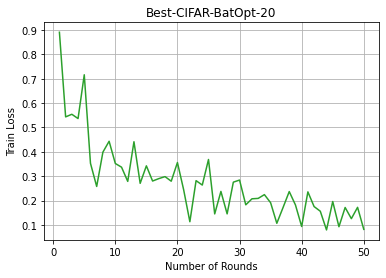

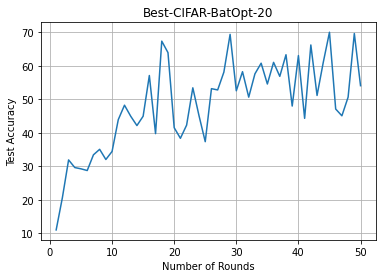

In [19]:
# number of training rounds
rounds = 50
# client fraction
CLIENT_FRACTION = 0.1
# number of clients
TOTAL_CLIENTS = 20
# number of training passes on local dataset for each round
TRAINING_EPOCHS = 5
# percentage of high power client
HIGHP_CLIENT_PERCENTAGE = 0.5
# number of training passes on local dataset for each round for low power client
LOWP_TRAINING_EPOCHS = 5
# batch size
batch_size = 50
# learning Rate
lr=0.01
# dict containing different type of data partition
data_dict = non_iid_partition(cifar_data_train, 20, 80, 625, 4)
# data_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()
cifar_cnn = CIFAR_CNN()
mnist_cnn_s = MNIST_CNN_S()

if torch.cuda.is_available():
#   mnist_cnn.cuda()
  cifar_cnn.cuda()
  mnist_cnn_s.cuda()

mnist_cnn_non_iid_trained = training(cifar_cnn, rounds, batch_size, lr, cifar_data_train, data_dict, CLIENT_FRACTION, \
                                     TOTAL_CLIENTS, TRAINING_EPOCHS, LOWP_TRAINING_EPOCHS, HIGHP_CLIENT_PERCENTAGE, \
                                     "Best-CIFAR-BatOpt-20", "green")
criterion = nn.CrossEntropyLoss()
testing(mnist_cnn_non_iid_trained, cifar_data_test, 128, criterion, num_classes, classes_test)

### Test

## MNIST CNN on 50/50

### Train